# Supervised Text Classification for Wellness & Health.

The Rubric is as follows:

1. You building a replicable model that can be rerun via python without errors
2. Your ability to report and interpret validation set metrics
3. The quality and professionalism of a 5-minute video overviewing what you did
4. How detailed you were at tuning parameters, exploring preprocessing techniques and using transformers/embeddings
5. How predictive it is compared to your classmates


## Instruction

Imagine you're working at a media buying company, Chrishare. They have a new client,
Theragun

Theragun knows that consumers who value health and wellness are more likely to consider, and ultimately buy their product. So, they’d like to find health and wellness news around the web to advertise on. Their goal with their media campaign is to identify as many news articles that mention health and wellness as possible.

Your challenge now is to build a deep learning algorithm that predicts the probability that a news story is about health and wellness. You’ll be using `k-train`, which is a wrapper for
Tensorflow, Keras, and Huggingface Transformers.


## Final Project Introduction

In this final project, I will utilize Ktrain, a lightweight wrapper for TensorFlow Keras, to train a model. The model’s objective is to determine whether a news article pertains to Health or Wellness. By separating the dataset provided into (1) Healthy and (0) Not Healthy categories based on Headline/Category, I will enable the model to make predictions and assess its accuracy.

Following training, I have established a test to evaluate the model’s performance using precision, recall, and F1-score metrics. Additionally, I have included untrained on examples to demonstrate the model’s ability to predict whether articles are related to Health.

During the project, I encountered several challenges that required considerable effort to overcome. Initially, Ktrain did not function properly out of the box. To resolve this issue, I needed to install specific versions of certain libraries. Also, while attempting to build the model, I used all my Colab pro credits for TPU usage. This made me relocated my work to Kaggle to utilize their TPU resources.

To access Kaggle’s TPU VM v3-8, I had to wait in a queue after each attempt. After numerous attempts and encounters with errors, I suspected that the long training time on Kaggle’s TPU was causing Kaggle to interrupt training process. Consequently, to ensure the completion of the training, I adjusted the Epochs for identifying the optimal learning rate to two Epochs and reduced the Training to one Epoch, as training would be interrupted after three total Epochs.

This bottleneck presents a significant challenge in training a highly effective model. While I apologize for any imperfections in the results, I worked hard to make the most of the available resources.


In [ ]:
!pip install -U tf_keras

In [ ]:
!pip install ktrain==0.41.4 tensorflow==2.15.0 tf_keras==2.15.1

In [ ]:
# Importing necessary packages
import os
os.environ["TF_USE_LEGACY_KERAS"] = '1'

try:
  import ktrain
except:
  !pip install ktrain
  #os.kill(os.getpid(), 9)
    
import ktrain
import pandas as pd
import numpy as np
import requests

In [4]:
# Loading from ktrain
from ktrain import text
from ktrain.text import texts_from_df

In [5]:
print(ktrain.__version__)

0.41.4


### Load Data


In [ ]:
# Load data
data = pd.read_csv(
    "/kaggle/input/news-category-training-data-csv/news_category_trainingdata.csv"
)
print("Data loaded. Shape:", data.shape)
print("Data Info:", data.info)

Data loaded. Shape: (200853, 6)
Data Info: <bound method DataFrame.info of              category                                           headline  \
0               CRIME  There Were 2 Mass Shootings In Texas Last Week...   
1       ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   
2       ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   
3       ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   
4       ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   
...               ...                                                ...   
200848           TECH  RIM CEO Thorsten Heins' 'Significant' Plans Fo...   
200849         SPORTS  Maria Sharapova Stunned By Victoria Azarenka I...   
200850         SPORTS  Giants Over Patriots, Jets Over Colts Among  M...   
200851         SPORTS  Aldon Smith Arrested: 49ers Linebacker Busted ...   
200852         SPORTS  Dwight Howard Rips Teammates After Magic Loss ...   

            

# Creating Combined Feature

Here we want to create a new feature that adds the headline and the short_description together because ktrain works with only one text feature as input for text classification.


In [ ]:
# Feature engineering
data["feature"] = data["headline"] + " " + data["short_description"]
print("Features created. First few rows:")
print(data[["feature", "category"]].head())

Features created. First few rows:
                                             feature       category
0  There Were 2 Mass Shootings In Texas Last Week...          CRIME
1  Will Smith Joins Diplo And Nicky Jam For The 2...  ENTERTAINMENT
2  Hugh Grant Marries For The First Time At Age 5...  ENTERTAINMENT
3  Jim Carrey Blasts 'Castrato' Adam Schiff And D...  ENTERTAINMENT
4  Julianna Margulies Uses Donald Trump Poop Bags...  ENTERTAINMENT


# Creating Variables

Here i set a new column `health` and use numpy to look for whether the category of an entry is equal to `WELLNESS` or `HEALTHY LIVING` and assigning in the new `health` column a 1 or a 0 if it is anything other than those two.


In [ ]:
# Creating Variables
data["health"] = np.where(
    (data["category"] == "WELLNESS") | (data["category"] == "HEALTHY LIVING"), 1, 0
)
print("Health label stats:\n", data["health"].describe())

Health label stats:
 count    200853.000000
mean          0.122084
std           0.327384
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: health, dtype: float64


### Balancing The Sample Data

I have less healthy entries than i have not healthy. So to help make sure the model is equally balanced and not overtrained for one side i limit the samples given to the model to train on.


In [ ]:
# Balancing
sample_amt = int(data["health"].sum())
print("Sample size:", sample_amt)
wellness = data[data["health"] == 1]
not_wellness = data[data["health"] == 0].sample(n=sample_amt, random_state=42)
data_sample = pd.concat([wellness, not_wellness])
print("Balanced dataset stats:\n", data_sample.describe())

Sample size: 24521
Balanced dataset stats:
              health
count  49042.000000
mean       0.500000
std        0.500005
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000


### The Model


In [ ]:
# Preprocess with ktrain
target_names = ["NOT HEALTH", "HEALTH"]
train, val, preprocess = text.texts_from_df(
    data_sample,
    text_column="feature",
    label_columns=["health"],
    val_df=None,
    max_features=20000,
    maxlen=128,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1,
)
print("Data preprocessed successfully")

['not_health', 'health']
        not_health  health
192960         0.0     1.0
175454         1.0     0.0
21974          0.0     1.0
100456         1.0     0.0
169620         0.0     1.0
['not_health', 'health']
        not_health  health
98556          0.0     1.0
147299         1.0     0.0
149342         0.0     1.0
24535          0.0     1.0
19328          1.0     0.0


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 31
	95percentile : 58
	99percentile : 67


Data preprocessed successfully


In [11]:
# Define the model
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=32)

### Finding the learing rate

Here was were i ran into my first bottle neck where i tried to use 3 Epochs to find a good learning rate but in order to not time out the Kaggle TPU i dropped it down to 2 and you can see the Epoch training outputs below.


Finding optimal learning rate...
simulating training for different learning rates... this may take a few moments...
Epoch 1/2
1379/1379 [==============================] - 2474s 2s/step - loss: 0.4765 - accuracy: 0.7461
Epoch 2/2
1379/1379 [==============================] - 1010s 732ms/step - loss: 14.9076 - accuracy: 0.4940


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


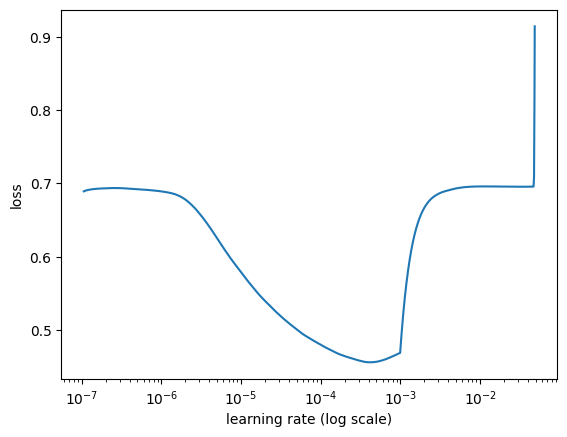

In [ ]:
# Finding the learning rate
print("Finding optimal learning rate...")
learner.lr_find(max_epochs=2)
learner.lr_plot()

### Training the Model

Here is the last part of training the actual model itself and i was only able to use 1 epoch for this to make sure i didnt get interrupted.


In [ ]:
# Train the model
learner.autofit(
    lr=1e-4,
    checkpoint_folder="/checkpoint",
    epochs=1,  # Reduced so to not get timedout by Kaggle
    early_stopping=True,
)



begin training using triangular learning rate policy with max lr of 0.0001...
1380/1380 [==============================] - 2476s 2s/step - loss: 0.2788 - accuracy: 0.8813 - val_loss: 0.2258 - val_accuracy: 0.9009
Weights from best epoch have been loaded into model.


In [ ]:
# Save predictor
predictor = ktrain.get_predictor(learner.model, preprocess)
predictor.save("wellness_predictor")
print("Model saved to /model/wellness_predictor")

### Validation

Here shows the scores for how the model performes. With only limited Epochs it did quite well.


In [15]:
# Validate model
validation = learner.validate(val_data=val, class_names=target_names)
print("Validation metrics:\n", validation)

154/154 [==============================] - 83s 511ms/step
              precision    recall  f1-score   support

  NOT HEALTH       0.90      0.90      0.90      2483
      HEALTH       0.90      0.90      0.90      2422

    accuracy                           0.90      4905
   macro avg       0.90      0.90      0.90      4905
weighted avg       0.90      0.90      0.90      4905

Validation metrics:
 [[2245  238]
 [ 248 2174]]


### Testing Predicitons

Below are a few news articles and i run them through the model and print out the prediction for whether they are health based or not. The output is very good and with high 90% probabilty and low sub 1% probability can correctly identify the correct articles for whether they are Health/Wellness Focused.


In [ ]:
# Test predictions
test_docs = [
    "Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.",
    "Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.",
    "What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.",
    "Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.",
    "Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.",
    "A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.",
]

for i, text in enumerate(test_docs):
    probs = predictor.predict(text, return_proba=True)
    print("---------------------------")
    print(f"The probability this is healthy is {probs[1]:.4f}")
    print(text)

---------------------------
The probability this is healthy is 0.9939
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
The probability this is healthy is 0.9404
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
The probability this is healthy is 0.9216
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
The probability this is healthy is 0.9558
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability this is healthy is 0.0041
Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney d